In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import yfinance as yf
import talib as ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
# Load data
start_date = '1800-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
symbol = "AAPL"
data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [5]:
data["Price Pct Change"] = data["Adj Close"].pct_change()
data["Price Pct Change"] = data["Price Pct Change"].shift(-1)
data["Price Pct Change"] = data["Price Pct Change"].fillna(0)

data["Dollar Volume"] = data["Adj Close"] * data["Volume"]
data["Dollar Volume Pct Change"] = data["Dollar Volume"].pct_change()
data["Dollar Volume Pct Change"] = data["Dollar Volume Pct Change"].shift(-1)

data.head()

,Open,High,Low,Close,Adj Close,Volume,Price Pct Change,Dollar Volume,Dollar Volume Pct Change
Date,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098834,469033600,-0.052170,4.635668e+07,-0.644570
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093678,175884800,-0.073398,1.647658e+07,-0.443000
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086802,105728000,0.024751,9.177449e+06,-0.162179
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.088951,86441600,0.028992,7.689057e+06,-0.125663
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091530,73449600,0.061028,6.722826e+06,-0.297501


In [7]:
#moving average
data["MA5"] = data["Adj Close"].rolling(window=5).mean()
data["MA20"] = data["Adj Close"].rolling(window=20).mean()
data["MA50"] = data["Adj Close"].rolling(window=50).mean()
data["MA200"] = data["Adj Close"].rolling(window=200).mean()

#RSI
data["RSI"] = ta.RSI(data["Adj Close"], timeperiod=14)

#MACD
data["MACD"], data["Signal Line"], data["MACD Histogram"] = ta.MACD(data["Adj Close"], fastperiod=12, slowperiod=26, signalperiod=9)

#Bollinger Bands
data["Upper Band"], data["Middle Band"], data["Lower Band"] = ta.BBANDS(data["Adj Close"], timeperiod=20)

data = data.dropna()

data.head()



,Open,High,Low,Close,Adj Close,Volume,Price Pct Change,Dollar Volume,Dollar Volume Pct Change,MA5,MA20,MA50,MA200,RSI,MACD,Signal Line,MACD Histogram,Upper Band,Middle Band,Lower Band
Date,,,,,,,,,,,,,,,,,,,,
1981-09-28,0.064174,0.064732,0.064174,0.064174,0.049417,91728000,0.052171,4.532943e+06,0.086087,0.053886,0.063684,0.072914,0.090962,19.460642,-0.005966,-0.004878,-0.001088,0.077784,0.063684,0.049584
1981-09-29,0.067522,0.068080,0.067522,0.067522,0.051995,94684800,0.008264,4.923171e+06,-0.467602,0.052683,0.062824,0.072295,0.090728,27.078648,-0.006017,-0.005106,-0.000911,0.077560,0.062824,0.048089
1981-09-30,0.068080,0.068638,0.068080,0.068080,0.052425,49996800,0.000000,2.621085e+06,0.222670,0.051824,0.061772,0.071694,0.090522,28.295983,-0.005954,-0.005275,-0.000678,0.076318,0.061772,0.047225
1981-10-01,0.068080,0.068638,0.068080,0.068080,0.052425,61129600,0.081977,3.204723e+06,-0.202691,0.051050,0.060654,0.071187,0.090350,28.295983,-0.005836,-0.005388,-0.000449,0.074449,0.060654,0.046860
1981-10-02,0.073661,0.074219,0.073661,0.073661,0.056723,45046400,0.030301,2.555154e+06,-0.014272,0.052597,0.059945,0.070723,0.090189,39.928400,-0.005335,-0.005377,0.000042,0.072998,0.059945,0.046893


Epoch 1/20


/Users/pratikk/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 1.4508e-04
Epoch 2/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 1.8956e-06
Epoch 3/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 1.8364e-06
Epoch 4/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 1.9053e-06
Epoch 5/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 1.7375e-06
Epoch 6/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 1.4949e-06
Epoch 7/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 1.4312e-06
Epoch 8/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 1.5903e-06
Epoch 9/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 1.5576e-06
Epoch 10/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 1.4747e-06
Epoch 11/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 1.5458e-06
Epoch 12/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 1.4666e-06
Epoch 13/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 1.1173e-06
Epoch 14/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 1.1209e

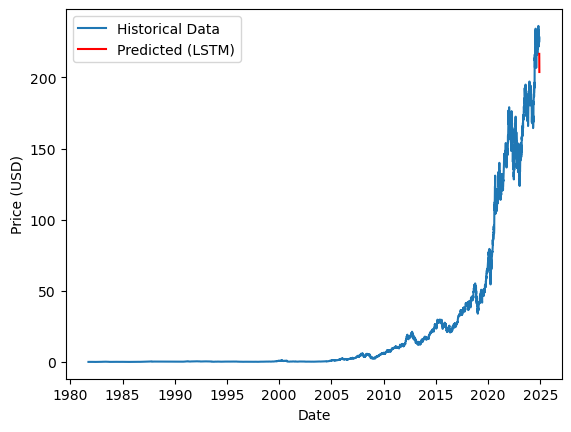

[[216.5713 ]
 [214.34782]
 [211.11732]
 [207.5205 ]
 [203.81938]]


In [10]:
# Use adjusted closing prices
closing_prices = data[['Adj Close']]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Prepare training and testing datasets
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

# Prepare data for LSTM
look_back = 60  # Number of past days to consider
X, y = create_dataset(scaled_data, look_back)

# Reshape X to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Predict for the next 5 days
inputs = scaled_data[-look_back:]
inputs = inputs.reshape(1, look_back, 1)
predictions = []

for _ in range(5):
    pred = model.predict(inputs)[0][0]
    predictions.append(pred)
    
    # Reshape `pred` to have the same dimensions as `inputs` for concatenation
    pred_reshaped = np.array(pred).reshape(1, 1, 1)
    
    # Append the prediction to the end of inputs and shift the window
    inputs = np.append(inputs[:, 1:, :], pred_reshaped, axis=1)

# Convert predictions back to original scale
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Display the predictions
import matplotlib.pyplot as plt

plt.plot(closing_prices.index, closing_prices['Adj Close'], label='Historical Data')
future_dates = pd.date_range(start=closing_prices.index[-1] + pd.Timedelta(days=1), periods=5)
plt.plot(future_dates, predicted_prices, label='Predicted (LSTM)', color='red')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

print(predicted_prices)